# Liberías

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import plotly.express as px
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

# Carga de datos

In [35]:
archivo = "data/gen/cleaned.csv"
df = pd.read_csv(archivo)
df.head()

,ANO_EMISION,MES_EMISION,DIA_EMISION,REG_MCPIO,QUIEN_REPORTA,VIC_SEXO,VIC_EDAD,TOTAL_HIJOS,NUM_HIJ_HOM,NUM_HIJ_MUJ,...,AGR_OTROS_N_OS,AGR_OTRAS_N_AS,INST_DENUN_HECHO,LEY_APLICABLE,FECHA_EMISION,FECHA_HECHO,REG_DPTO,HEC_DPTO,MEDIDAS_SEGURIDAD,CONTEXTO_DE_VIC
0,2013,1,22,guatemala,Víctima,Mujeres,38.0,2,1,1,...,0.0,0.0,Organismo Judicial,Ambas leyes (VIF y VCM),2013-01-22,2013-01-19,guatemala,guatemala,Dto. 22-2008,2
1,2013,1,24,guatemala,Víctima,Mujeres,20.0,1,0,1,...,99.0,99.0,Ministerio Público,NaN,2013-01-24,2013-01-23,guatemala,guatemala,Dto. 22-2008,2
2,2013,1,21,guatemala,Víctima,Mujeres,21.0,2,1,1,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-21,2013-01-21,guatemala,guatemala,Dto. 22-2008,1
3,2013,1,2,guatemala,Víctima,Hombres,70.0,0,0,0,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-02,2013-01-02,guatemala,guatemala,Dto. 97-96,2
4,2013,1,10,guatemala,Víctima,Mujeres,36.0,99,99,99,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-10,2013-01-10,guatemala,guatemala,Dto. 22-2008,2


# Variables de interés

In [36]:
victimaDf = df[["QUIEN_REPORTA","VIC_SEXO", "VIC_EDAD", "TOTAL_HIJOS", "VIC_ALFAB", "VIC_ESCOLARIDAD", "VIC_EST_CIV", "VIC_GRUPET", "VIC_TRABAJA", "VIC_DEDICA" ,"VIC_DISC"]]
victimaDf.head()

,QUIEN_REPORTA,VIC_SEXO,VIC_EDAD,TOTAL_HIJOS,VIC_ALFAB,VIC_ESCOLARIDAD,VIC_EST_CIV,VIC_GRUPET,VIC_TRABAJA,VIC_DEDICA,VIC_DISC
0,Víctima,Mujeres,38.0,2,Si,49.0,Casados(as),Ladinos(as),Si,Secretarios (general),No
1,Víctima,Mujeres,20.0,1,Si,31.0,Unidos(as),Ladinos(as),Si,Asistentes de venta de tiendas y almacenes,No
2,Víctima,Mujeres,21.0,2,Si,29.0,Solteros(as),Maya,No,Quehaceres del hogar,No
3,Víctima,Hombres,70.0,0,Si,49.0,Casados(as),Ladinos(as),No,Vive de sus renta o jubilación,No
4,Víctima,Mujeres,36.0,99,Si,59.0,Casados(as),Ladinos(as),Si,Directores generales y gerentes generales,No


# Preprocesamiento

In [37]:
categorical_features = victimaDf.select_dtypes(exclude=['number']).columns
numeric_features = victimaDf.select_dtypes(include=['number']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

victima_preprocessed = preprocessor.fit_transform(victimaDf)

# Clustering

In [38]:
# Definir número de clústeres aleatorio (k)
k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(victima_preprocessed)
clusters = kmeans.labels_

victimaDf['cluster'] = clusters

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_8321/4001160999.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Visualización con PCA

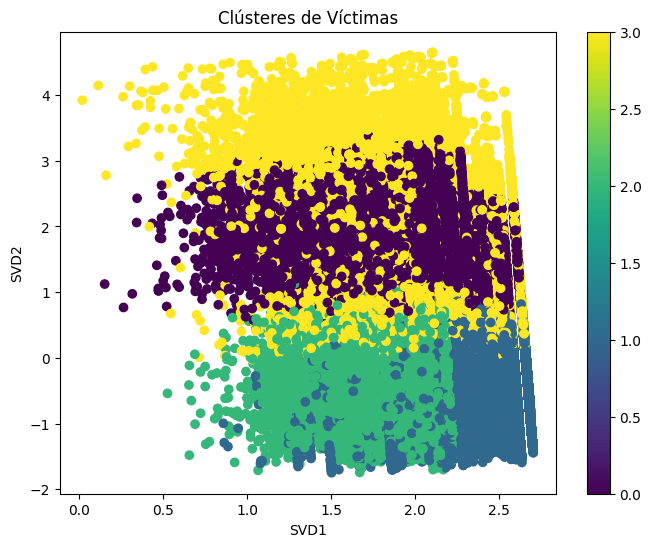

In [39]:
svd = TruncatedSVD(n_components=2)
victima_2d = svd.fit_transform(victima_preprocessed)

pca_df = pd.DataFrame(data=victima_2d, columns=['SVD1', 'SVD2'])
pca_df['cluster'] = clusters

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['SVD1'], pca_df['SVD2'], c=pca_df['cluster'], cmap='viridis')
plt.xlabel('SVD1')
plt.ylabel('SVD2')
plt.title('Clústeres de Víctimas')
plt.colorbar()
plt.show()

# Búsqueda del número óptimo de clusters

## Método del codo

In [40]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

wcss = []
for k in range(1,11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(victima_preprocessed)
  wcss.append(kmeans.inertia_)

datos_WCSS = pd.DataFrame(range(1, 11), columns = ["K"])
datos_WCSS["WCSS"] = wcss

fig = px.line(datos_WCSS, x = "K", y = "WCSS")
fig.show()

localizador_codo = KneeLocator(range(1, 11), wcss, curve = 'convex', direction = "decreasing")
print(f"\n La cantidad de clusteres debe ser {localizador_codo.elbow}")


 La cantidad de clusteres debe ser 4


# Aplicación de número óptimo de clusters

# Clustering

In [41]:
# Definir número de clústeres (k)
k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(victima_preprocessed)
clusters = kmeans.labels_

victimaDf['cluster'] = clusters
df['CONTEXTO_DE_VIC'] = clusters

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_8321/2781379950.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Visualización con PCA

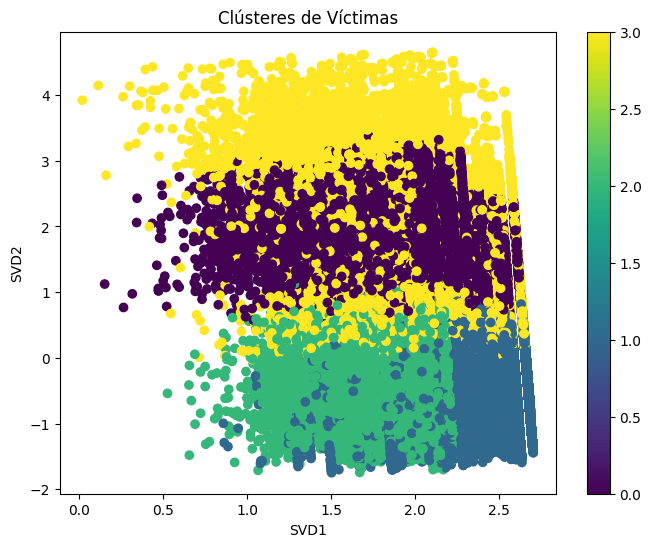

In [42]:
svd = TruncatedSVD(n_components=2)
victima_2d = svd.fit_transform(victima_preprocessed)

pca_df = pd.DataFrame(data=victima_2d, columns=['SVD1', 'SVD2'])
pca_df['cluster'] = clusters

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['SVD1'], pca_df['SVD2'], c=pca_df['cluster'], cmap='viridis')
plt.xlabel('SVD1')
plt.ylabel('SVD2')
plt.title('Clústeres de Víctimas')
plt.colorbar()
plt.show()

# Análisis de los clusters

In [43]:
columnas = ["QUIEN_REPORTA","VIC_SEXO", "VIC_EDAD", "TOTAL_HIJOS", "VIC_ALFAB", "VIC_ESCOLARIDAD", "VIC_EST_CIV", "VIC_GRUPET", "VIC_TRABAJA", "VIC_DEDICA" ,"VIC_DISC"]

## Cluster 0

In [44]:
cluster_0 = victimaDf[victimaDf['cluster'] == 0]

In [45]:
for columna in columnas:
    print(cluster_0[columna].value_counts())
    print("\n")

QUIEN_REPORTA
Víctima                   60111
Familiar de la víctima     1211
Ignorado                    765
Otro                        339
Name: count, dtype: int64


VIC_SEXO
Mujeres    58311
Hombres     4115
Name: count, dtype: int64


VIC_EDAD
30.0    2295
35.0    2116
32.0    2058
40.0    2016
28.0    1960
        ... 
74.0      65
13.0      53
12.0      36
76.0      10
77.0       2
Name: count, Length: 66, dtype: int64


TOTAL_HIJOS
99    11693
2     10010
1      9942
3      8631
0      6826
4      5842
5      3950
6      2218
7      1402
8       871
9       428
10      319
11      133
12       94
13       38
14       12
15       11
16        4
17        1
19        1
Name: count, dtype: int64


VIC_ALFAB
No          48803
Si          12416
Ignorado     1207
Name: count, dtype: int64


VIC_ESCOLARIDAD
99.0    62426
Name: count, dtype: int64


VIC_EST_CIV
Casados(as)     24420
Unidos(as)      18588
Ignorado         8841
Solteros(as)     8196
Otro             1715
Viudos(as)     

Mayoría víctimas mujeres, las edades se centralizan en los 30 años. Un número de hijos de 0-4. La mayoría son analfabetas. La mayoría no cuenta con estudios. Mayoría casadas o unidas. Grupo étnico Maya por mayoría. La mayoría no cuenta con un trabajo o se dedica a los quehaceres del hogar. Mayoría sin discapacidad.

En resumen, podríamos decir que este grupo es de mujeres adultas jóvenes que pertenecen a comunidades mayas con familias pequeñas/medianas.

## Cluster 1

In [46]:
cluster_1 = victimaDf[victimaDf['cluster'] == 1]

In [47]:
for columna in columnas:
    print(cluster_1[columna].value_counts())
    print("\n")

QUIEN_REPORTA
Víctima                   141501
Familiar de la víctima      2296
Ignorado                    1478
Otro                         839
Name: count, dtype: int64


VIC_SEXO
Mujeres    144296
Hombres      1818
Name: count, dtype: int64


VIC_EDAD
23.0    7605
22.0    7483
25.0    7090
24.0    6855
21.0    6836
20.0    6802
26.0    6340
30.0    6125
28.0    6118
27.0    6089
19.0    5959
29.0    5618
18.0    5326
32.0    4900
33.0    4460
31.0    4451
35.0    4064
34.0    3820
17.0    3589
38.0    3331
36.0    3297
37.0    3243
40.0    2866
39.0    2731
42.0    2252
16.0    2093
41.0    1931
43.0    1912
45.0    1517
44.0    1449
15.0    1233
46.0    1012
47.0     967
48.0     924
14.0     793
50.0     785
49.0     730
52.0     641
51.0     524
53.0     521
13.0     470
54.0     434
55.0     340
12.0     270
56.0     212
57.0      84
58.0      22
Name: count, dtype: int64


TOTAL_HIJOS
1     39443
2     32658
99    22886
3     19145
0     18393
4      7715
5      3259
6      13

Mayoría mujeres. Una distribución uniforme entre las edades de 20-30 años. Todas sin hijos registrados. Mayoría alfabeta. Aunque se ignoró el grado escolar de la mayoría, quienes le siguen son personas que terminaron cierto grado escolar. La mayoría son casadas. La mayoría pertenece al grupo étnico Ladino. La mayoría no trabaja. Mayoría sin discapacidad.

En resumen, podríamos decir que este grupo es de mujeres jóvenes adultas con educación y desempleadas.

## Cluster 2

In [48]:
cluster_2 = victimaDf[victimaDf['cluster'] == 2]

In [49]:
for columna in columnas:
    print(cluster_2[columna].value_counts())
    print("\n")

QUIEN_REPORTA
Víctima                   86208
Ignorado                    915
Familiar de la víctima      695
Otro                        112
Name: count, dtype: int64


VIC_SEXO
Mujeres    63726
Hombres    24204
Name: count, dtype: int64


VIC_EDAD
28.0    4154
30.0    4119
32.0    3852
27.0    3827
29.0    3820
26.0    3693
25.0    3653
31.0    3596
33.0    3527
34.0    3446
24.0    3443
35.0    3331
23.0    3237
36.0    3016
38.0    2974
37.0    2863
22.0    2841
40.0    2565
39.0    2354
21.0    2337
42.0    2121
20.0    1893
41.0    1869
43.0    1677
44.0    1435
45.0    1384
19.0    1322
46.0    1068
47.0     989
48.0     949
18.0     792
50.0     680
49.0     673
52.0     611
51.0     567
53.0     501
54.0     427
55.0     416
17.0     366
56.0     364
58.0     318
57.0     316
16.0     161
59.0     154
15.0      97
60.0      84
14.0      23
13.0      16
61.0       7
12.0       2
Name: count, dtype: int64


TOTAL_HIJOS
2     21811
1     21255
3     13522
99    13276
0      9411


La mayoría son mujeres. Edades concentradas en los 30 años. Numéro de hijos entre 1-3. Todas alfabetas. Todas con mínimo un año escolar alto. Mayoría casadas o unidas. Mayoría Ladinas. Mayoría hacen los quehaceres del hogar o son vendedoras no clasificadas. Mayoría sin discapacidad.

En resumen, podríamos decir que este grupo son mujeres jóvenes adultas con familias pequeñas con cierto ingreso.

## Cluster 3

In [50]:
cluster_3 = victimaDf[victimaDf['cluster'] == 3]

In [51]:
for columna in columnas:
    print(cluster_3[columna].value_counts())
    print("\n")

QUIEN_REPORTA
Víctima                   22320
Familiar de la víctima      504
Ignorado                    365
Otro                        119
Name: count, dtype: int64


VIC_SEXO
Mujeres    15854
Hombres     7454
Name: count, dtype: int64


VIC_EDAD
98.0    4286
60.0     948
62.0     786
65.0     703
59.0     693
        ... 
40.0       8
41.0       7
97.0       5
38.0       4
39.0       2
Name: count, Length: 61, dtype: int64


TOTAL_HIJOS
99    11066
3      2118
2      2061
1      1840
0      1703
4      1606
5      1188
6       606
7       443
8       263
9       147
10      126
11       61
12       50
13       13
14        8
15        4
17        3
16        2
Name: count, dtype: int64


VIC_ALFAB
Si          19058
No           3917
Ignorado      333
Name: count, dtype: int64


VIC_ESCOLARIDAD
99.0    5647
29.0    4297
26.0    2979
49.0    2059
39.0    1343
23.0    1199
46.0    1025
33.0     944
22.0     943
59.0     697
24.0     461
21.0     403
45.0     316
25.0     303
32.0     

Mayoría mujeres. Edades menores a 25 años. Número de hijos entre 0-2. Todas alfabetas. Mayoría casadas o unidas. Mayoría del grupo étnico Maya. Mayoría amas de casa o vendedoras. Mayoría sin discapacidad. 

En resumen, podríamos decir que este grupo son mujeres jóvenes rurales con familias pequeñas y ocupaciones variadas

In [20]:
df.head()

,ANO_EMISION,MES_EMISION,DIA_EMISION,REG_MCPIO,QUIEN_REPORTA,VIC_SEXO,VIC_EDAD,TOTAL_HIJOS,NUM_HIJ_HOM,NUM_HIJ_MUJ,...,AGR_OTRAS_N_AS,INST_DENUN_HECHO,LEY_APLICABLE,FECHA_EMISION,FECHA_HECHO,REG_DPTO,HEC_DPTO,MEDIDAS_SEGURIDAD,Cluster,CONTEXTO_DE_VIC
0,2013,1,22,guatemala,Víctima,Mujeres,38.0,2,1,1,...,0.0,Organismo Judicial,Ambas leyes (VIF y VCM),2013-01-22,2013-01-19,guatemala,guatemala,Dto. 22-2008,2,2
1,2013,1,24,guatemala,Víctima,Mujeres,20.0,1,0,1,...,99.0,Ministerio Público,NaN,2013-01-24,2013-01-23,guatemala,guatemala,Dto. 22-2008,2,2
2,2013,1,21,guatemala,Víctima,Mujeres,21.0,2,1,1,...,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-21,2013-01-21,guatemala,guatemala,Dto. 22-2008,1,1
3,2013,1,2,guatemala,Víctima,Hombres,70.0,0,0,0,...,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-02,2013-01-02,guatemala,guatemala,Dto. 97-96,3,2
4,2013,1,10,guatemala,Víctima,Mujeres,36.0,99,99,99,...,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-10,2013-01-10,guatemala,guatemala,Dto. 22-2008,2,2


In [52]:
victimaDf.head()

,QUIEN_REPORTA,VIC_SEXO,VIC_EDAD,TOTAL_HIJOS,VIC_ALFAB,VIC_ESCOLARIDAD,VIC_EST_CIV,VIC_GRUPET,VIC_TRABAJA,VIC_DEDICA,VIC_DISC,cluster
0,Víctima,Mujeres,38.0,2,Si,49.0,Casados(as),Ladinos(as),Si,Secretarios (general),No,2
1,Víctima,Mujeres,20.0,1,Si,31.0,Unidos(as),Ladinos(as),Si,Asistentes de venta de tiendas y almacenes,No,2
2,Víctima,Mujeres,21.0,2,Si,29.0,Solteros(as),Maya,No,Quehaceres del hogar,No,1
3,Víctima,Hombres,70.0,0,Si,49.0,Casados(as),Ladinos(as),No,Vive de sus renta o jubilación,No,3
4,Víctima,Mujeres,36.0,99,Si,59.0,Casados(as),Ladinos(as),Si,Directores generales y gerentes generales,No,2


In [53]:
df.head()

,ANO_EMISION,MES_EMISION,DIA_EMISION,REG_MCPIO,QUIEN_REPORTA,VIC_SEXO,VIC_EDAD,TOTAL_HIJOS,NUM_HIJ_HOM,NUM_HIJ_MUJ,...,AGR_OTROS_N_OS,AGR_OTRAS_N_AS,INST_DENUN_HECHO,LEY_APLICABLE,FECHA_EMISION,FECHA_HECHO,REG_DPTO,HEC_DPTO,MEDIDAS_SEGURIDAD,CONTEXTO_DE_VIC
0,2013,1,22,guatemala,Víctima,Mujeres,38.0,2,1,1,...,0.0,0.0,Organismo Judicial,Ambas leyes (VIF y VCM),2013-01-22,2013-01-19,guatemala,guatemala,Dto. 22-2008,2
1,2013,1,24,guatemala,Víctima,Mujeres,20.0,1,0,1,...,99.0,99.0,Ministerio Público,NaN,2013-01-24,2013-01-23,guatemala,guatemala,Dto. 22-2008,2
2,2013,1,21,guatemala,Víctima,Mujeres,21.0,2,1,1,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-21,2013-01-21,guatemala,guatemala,Dto. 22-2008,1
3,2013,1,2,guatemala,Víctima,Hombres,70.0,0,0,0,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-02,2013-01-02,guatemala,guatemala,Dto. 97-96,3
4,2013,1,10,guatemala,Víctima,Mujeres,36.0,99,99,99,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-10,2013-01-10,guatemala,guatemala,Dto. 22-2008,2


In [54]:
df.to_csv('data/gen/cleaned.csv', index=False)